Epoch [1/50], Loss: 2.6193
Epoch [2/50], Loss: 2.4733
Epoch [3/50], Loss: 2.3664
Epoch [4/50], Loss: 2.2652
Epoch [5/50], Loss: 2.1533
Epoch [6/50], Loss: 2.0819
Epoch [7/50], Loss: 2.0071
Epoch [8/50], Loss: 1.9504
Epoch [9/50], Loss: 1.9152
Epoch [10/50], Loss: 1.8682
Epoch [11/50], Loss: 1.8123
Epoch [12/50], Loss: 1.7825
Epoch [13/50], Loss: 1.7479
Epoch [14/50], Loss: 1.7010
Epoch [15/50], Loss: 1.6756
Epoch [16/50], Loss: 1.6415
Epoch [17/50], Loss: 1.6221
Epoch [18/50], Loss: 1.5788
Epoch [19/50], Loss: 1.5584
Epoch [20/50], Loss: 1.5262
Epoch [21/50], Loss: 1.4867
Epoch [22/50], Loss: 1.4340
Epoch [23/50], Loss: 1.4114
Epoch [24/50], Loss: 1.3894
Epoch [25/50], Loss: 1.3683
Epoch [26/50], Loss: 1.3468
Epoch [27/50], Loss: 1.3117
Epoch [28/50], Loss: 1.2776
Epoch [29/50], Loss: 1.2604
Epoch [30/50], Loss: 1.2323
Epoch [31/50], Loss: 1.2221
Epoch [32/50], Loss: 1.1684
Epoch [33/50], Loss: 1.1696
Epoch [34/50], Loss: 1.1147
Epoch [35/50], Loss: 1.0728
Epoch [36/50], Loss: 1.0762
E

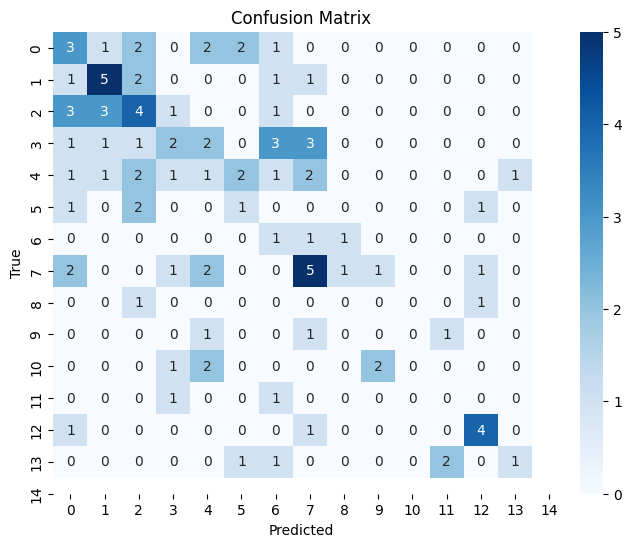

Cohen's Kappa with quadratic weights: 0.5540
Mean Absolute Error: 2.5392


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
data = pd.read_csv(r'D:\Proga\AML\PPG_dataset\dataset_limited.csv') 

# Удаление пропущенных значений
data.dropna(inplace=True)

if np.any(np.isinf(data.values)):
    data = data[np.isfinite(data).all(axis=1)]
    
# Выделение признаков и целевой переменной
X = data.drop(['id', 'age_group'], axis=1).values
y = data['age_group'].values - 1 

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Определение модели 1D CNN
class Simple1DCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Simple1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=4, kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=2, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(8 * 9, 128)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Добавляем канал
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Инициализация модели, функции потерь и оптимизатора
input_dim = X.shape[1]
num_classes = len(np.unique(y))
model = Simple1DCNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Оценка модели и сбор предсказаний
model.eval()
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test set: {100 * correct / total:.2f}%')

# Построение матрицы ошибок
cm = confusion_matrix(true_labels, predictions)

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Вычисление Cohen's Kappa с весами "quadratic"
kappa_quadratic = cohen_kappa_score(true_labels, predictions, weights="quadratic")
print(f'Cohen\'s Kappa with quadratic weights: {kappa_quadratic:.4f}')

# Вычисление MAE
mae = mean_absolute_error(true_labels, predictions)
print(f'Mean Absolute Error: {mae:.4f}')